# Q-learning model with neural networks

The idea is very similar to the one depicted in lab_week8 but rather than using RBF we will use a bunch of networks.

## Setup

In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
import os
# os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np

import virl
import utils

## Simulation

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from collections import namedtuple
from scipy.special import softmax

import itertools

env = virl.Epidemic(stochastic=False, noisy=False)

GLOBAL_SEED = 42

In [4]:
def create_policy(func_approximator, epsilon, num_actions):
    """
    Create an epsilon-greedy policy with the exploration defined by the epsilon and nA parameters
    
    args:
    - func_approximator: a function approximator that gives the probability Q(s, a) for a given state s
    - epsilon: the probability to select a random action (float between 0 and 1).
        If 0, the algorithm is perfectly deterministic.
    - num_actions: the number of actions
    
    return: A policy function. Policy functions take a state as input and return an action to perform.
    """
    
    def policy_fn(state):
        """
        Perform an action.
        
        Returns: a pair (A, q_values) where `A` is a list of scores for each action and
        q_values is the actual value returned by the approximator. For low values of epsilon,
        the 'best' action will be reinforced at A[best_action].
        """
        A = np.ones(num_actions, dtype=float) * epsilon / num_actions
        q_values = func_approximator.predict(state)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A, q_values
    
    return policy_fn
    
class FunctionApproximator:
    """
    Approximate Q(s, a) with a neural network
    """
    
    def __init__(self, hidden_layer_sizes=(100,), eta0=0.0001, optimizer="adam", learning_rate="constant"):
        """
        Set up the function approximator.
        
        args:
        - hidden_layer_sizes: the number of neurons in each layer.
        - eta0: (initial) learning rate.
        - optimizer: optimizer to use. Can be "adam", "rmsprop", "sgd" etc.
        - learning_rate: if the optimizer is sgd, then the learning rate will
            decrease over time. See sklearn.neural_network.MLPRegressor for details
        """
        
        self.eta0 = eta0
        self.optimizer = optimizer
        
        observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        
        self.models = []
        for i in range(env.action_space.n):
            model = Pipeline([
                #("scaler", StandardScaler().fit(observation_examples)),
                ("log", FunctionTransformer(lambda s: np.log10(np.array(s) + 1))),
                ("neural_network", MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, solver=optimizer, alpha=eta0, random_state=GLOBAL_SEED))
            ])
            
            # In order to perform training we need to perform active inference in the model.
            # However, sklearn does not let us do it before it is fitted.
            # Thus, use a partial_fit
            model.named_steps['neural_network'].partial_fit([env.reset()], [0])
            self.models.append(model)
        
    def predict(self, s, a = None):
        """
        Perform a prediction according to the approximation of Q(s, a)
        
        Args:
        - s: state to make predictions from extracted from the state space.
        - a: (Optional) action to make a prediction for.
        
        Return:
        - if a is not provided a list of scores of each action
        - if a is provided only the specific score of that action.
        """
        
        if a == None:
            return np.array([m.predict([s])[0] for m in self.models])
        else:
            return self.models[a].predict([s])[0]
    
    def update(self, s, a, y):
        """
        Update the model's parameters for a given state and action towards the target
        """
        self.models[a].named_steps['neural_network'].partial_fit([s], [y])

EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

def q_learning(env, func_approximator, num_episodes, discount_factor=1.0,
               epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algo for Q-learning using a generic function approximation.
    """

    np.random.seed(GLOBAL_SEED)
    
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    for i_episode in range(num_episodes):
        # Create a handle to the policy we're following
        # The basic idea is that in the first episodes random operations are allowed but then more and more
        # discouraged as the function approximator improves.
        policy = create_policy(func_approximator, epsilon * epsilon_decay ** i_episode, env.action_space.n )

        last_reward = stats.episode_rewards[i_episode - 1]

        state = env.reset()

        for t in itertools.count():
            # probe the policy and sample an action
            action_probs, q_vals = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            # Perform the action
            next_state, reward, done, _ = env.step(action)

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # Apply the Q-learning update equation
            q_values_next = func_approximator.predict(next_state)

            q_values_current = func_approximator.predict(state)

            td_target = reward + discount_factor * np.max(q_vals)

            func_approximator.update(state, action, td_target)
            
            if done:
                break

            
            state = next_state
            
        # Calculate mean
        stats.episode_rewards[i_episode] /= t
        
        print("\rEpisode {} ({})".format(i_episode+1, last_reward), end="")

    print("")
    return stats

Episode 100 (-0.018453689980575755)
0 [3, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2]


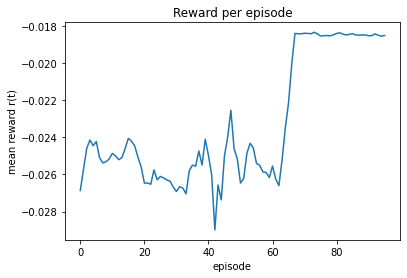

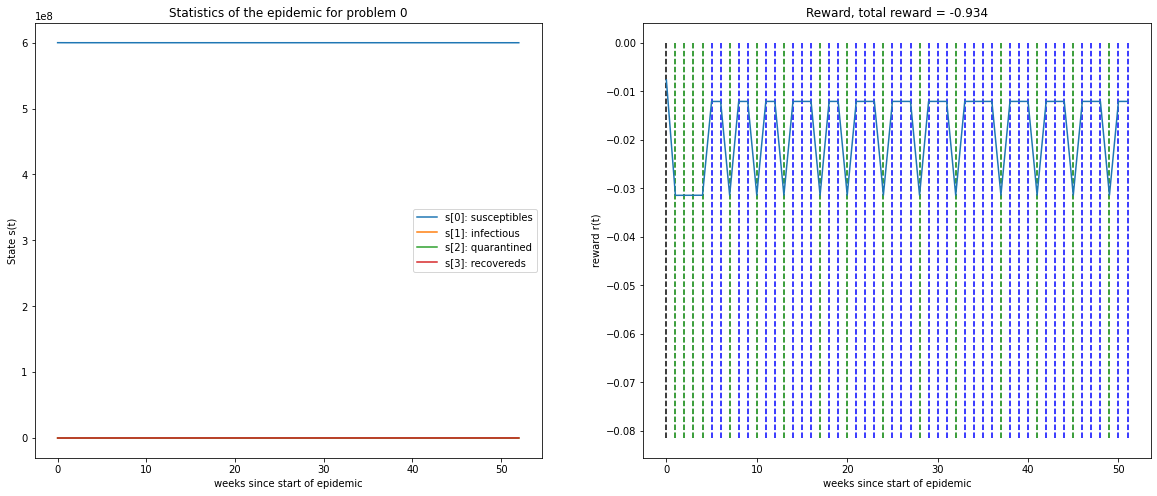

In [5]:
approximator_dl = FunctionApproximator(hidden_layer_sizes=(100,), eta0=0.05)
stats = q_learning(env, approximator_dl, 100, epsilon=0.1, epsilon_decay=1, discount_factor=.70)
utils.plot_avg_reward(stats.episode_rewards)
utils.evaluate(create_policy(approximator_dl, 0, 4))

## Analysis

We perform cross-validation across all possible problems: we train on each problem $i$ and test on each problem $j$.

We increase the number of epochs to 500 to highlight potential improvements.

Training on problem 0
Episode 500 (-0.018481665364125235)


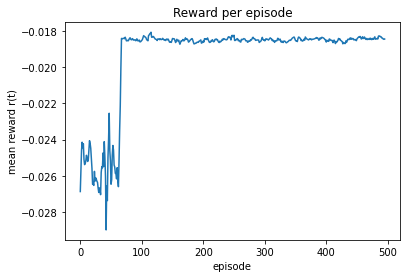

Training on problem 1
Episode 500 (-0.011074106230238717)


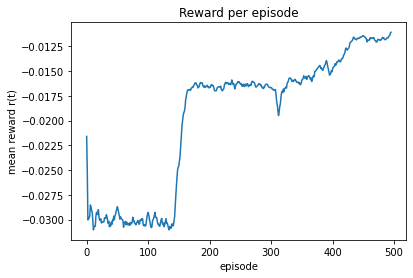

Training on problem 2
Episode 500 (-0.02955090835796549))


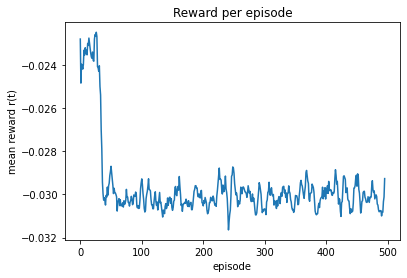

Training on problem 3
Episode 500 (-0.012214741837972443)


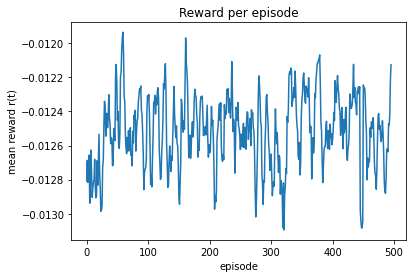

Training on problem 4
Episode 500 (-0.029550922854262706)


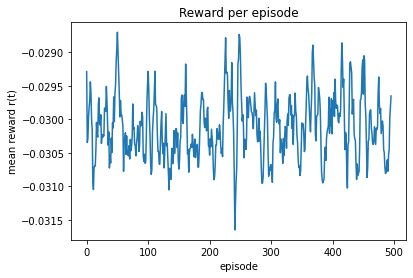

Training on problem 5
Episode 500 (-0.029550943131067025)


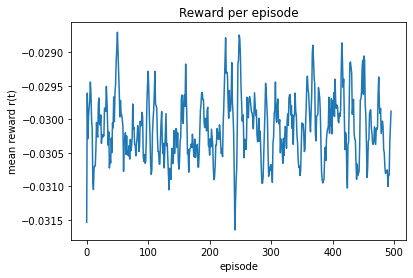

Training on problem 6
Episode 500 (-0.02273232797615786))


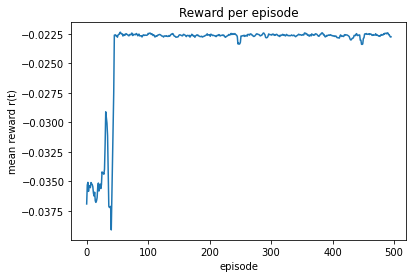

Training on problem 7
Episode 500 (-0.02955096749124485))


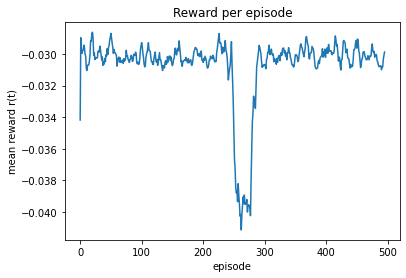

Training on problem 8
Episode 500 (-0.02349019945120211))


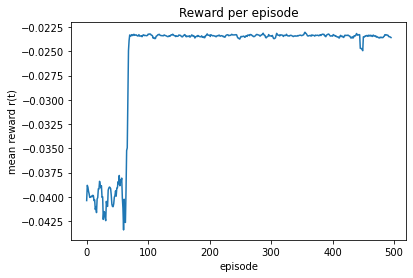

Training on problem 9
Episode 500 (-0.029091260503301953)


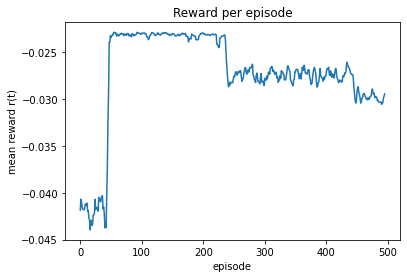

Trained on problem 0 & \textbf{0.93} & 0.68 & 0.7 & 0.72 & 0.84 & \textbf{1.01} & \textbf{1.07} & \textbf{1.13} & \textbf{1.17} & \textbf{1.2} & \textbf{\underline{0.95}}\\ 
Trained on problem 1 & 1.28 & 0.57 & \textbf{0.63} & \textbf{0.63} & \textbf{0.83} & 1.56 & 1.73 & 1.87 & 1.99 & 2.08 & 1.32\\ 
Trained on problem 2 & 1.46 & 1.46 & 1.46 & 1.46 & 1.46 & 1.46 & 1.46 & 1.46 & 1.46 & 1.46 & 1.46\\ 
Trained on problem 3 & 1.28 & \textbf{0.56} & 0.63 & 0.63 & 0.83 & 1.56 & 1.73 & 1.87 & 1.99 & 2.08 & 1.32\\ 
Trained on problem 4 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63\\ 
Trained on problem 5 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63\\ 
Trained on problem 6 & 1.02 & 0.98 & 0.98 & 0.98 & 0.98 & 1.09 & 1.15 & 1.19 & 1.23 & 1.25 & 1.08\\ 
Trained on problem 7 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63\\ 
Trained on problem 8 & 0.96 & 0.78 & 0.78 & 0.78 & 0.88 & 1.05 & 1.11 & 1.15 & 1.19

In [6]:
envs = [virl.Epidemic(problem_id=i) for i in range(10)]

full_rewards = []
policies = []

for i in range(10):
    print("Training on problem", i)
    approximator_dl = FunctionApproximator(hidden_layer_sizes=(100,), eta0=0.05)
    env = envs[i]
    stats = q_learning(env, approximator_dl, 500, epsilon=0.1, epsilon_decay=1, discount_factor=.70)
    utils.plot_avg_reward(stats.episode_rewards)
    policy = create_policy(approximator_dl, 0, 4)
    policies.append(policy)
    plt.show()
    
    for j in range(10):
        states, rewards, actions = utils.execute_policy(policy, envs[j])
        full_rewards.append(-np.sum(rewards))

# To copy on the LaTex report
print(utils.latex_table(np.array(full_rewards).reshape(10, 10), [f"Trained on problem {i}" for i in range(10)], include_means=True))

In [7]:
envs = [virl.Epidemic(problem_id=i, noisy=True) for i in range(10)]

full_rewards_noisy = []

for i in range(10):
    for j in range(10):
        states, rewards, actions = utils.execute_policy(policies[i], envs[j])
        full_rewards_noisy.append(-np.sum(rewards))

# To copy on the LaTex report
print(utils.latex_table(np.array(full_rewards_noisy).reshape(10, 10), [f"Trained on problem {i}" for i in range(10)], include_means=True))

Trained on problem 0 & \textbf{0.93} & 0.68 & 0.68 & 0.72 & 0.84 & \textbf{1.01} & \textbf{1.07} & \textbf{1.13} & \textbf{1.17} & \textbf{1.2} & \textbf{\underline{0.94}}\\ 
Trained on problem 1 & 1.28 & 0.57 & \textbf{0.63} & \textbf{0.63} & \textbf{0.83} & 1.56 & 1.73 & 1.87 & 1.99 & 2.08 & 1.32\\ 
Trained on problem 2 & 1.46 & 1.46 & 1.44 & 1.46 & 1.46 & 1.46 & 1.46 & 1.44 & 1.44 & 1.46 & 1.45\\ 
Trained on problem 3 & 1.28 & \textbf{0.56} & 0.63 & 0.63 & 0.83 & 1.56 & 1.73 & 1.87 & 1.99 & 2.08 & 1.32\\ 
Trained on problem 4 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63\\ 
Trained on problem 5 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63\\ 
Trained on problem 6 & 1.02 & 0.98 & 0.98 & 0.98 & 0.98 & 1.09 & 1.15 & 1.19 & 1.23 & 1.25 & 1.08\\ 
Trained on problem 7 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63 & 1.63\\ 
Trained on problem 8 & 0.96 & 0.78 & 0.78 & 0.78 & 0.88 & 1.05 & 1.11 & 1.15 & 1.1

Quite interestingly, training on problem 0 gives the best results in a range of problems. We will then train on problem 0.

Furthermore, the best scores are distributed along the first row rather than the main diagonal.

In [14]:
approximator_dl = policies[0]

## Full evaluation in noiseless environment

[-0.9338959555531453,
 -0.6826118991366483,
 -0.70194667929197,
 -0.7213163269619391,
 -0.837268113961144,
 -1.011224485529036,
 -1.0692238135830414,
 -1.1272596106583246,
 -1.1659811371244577,
 -1.2046822071445744]

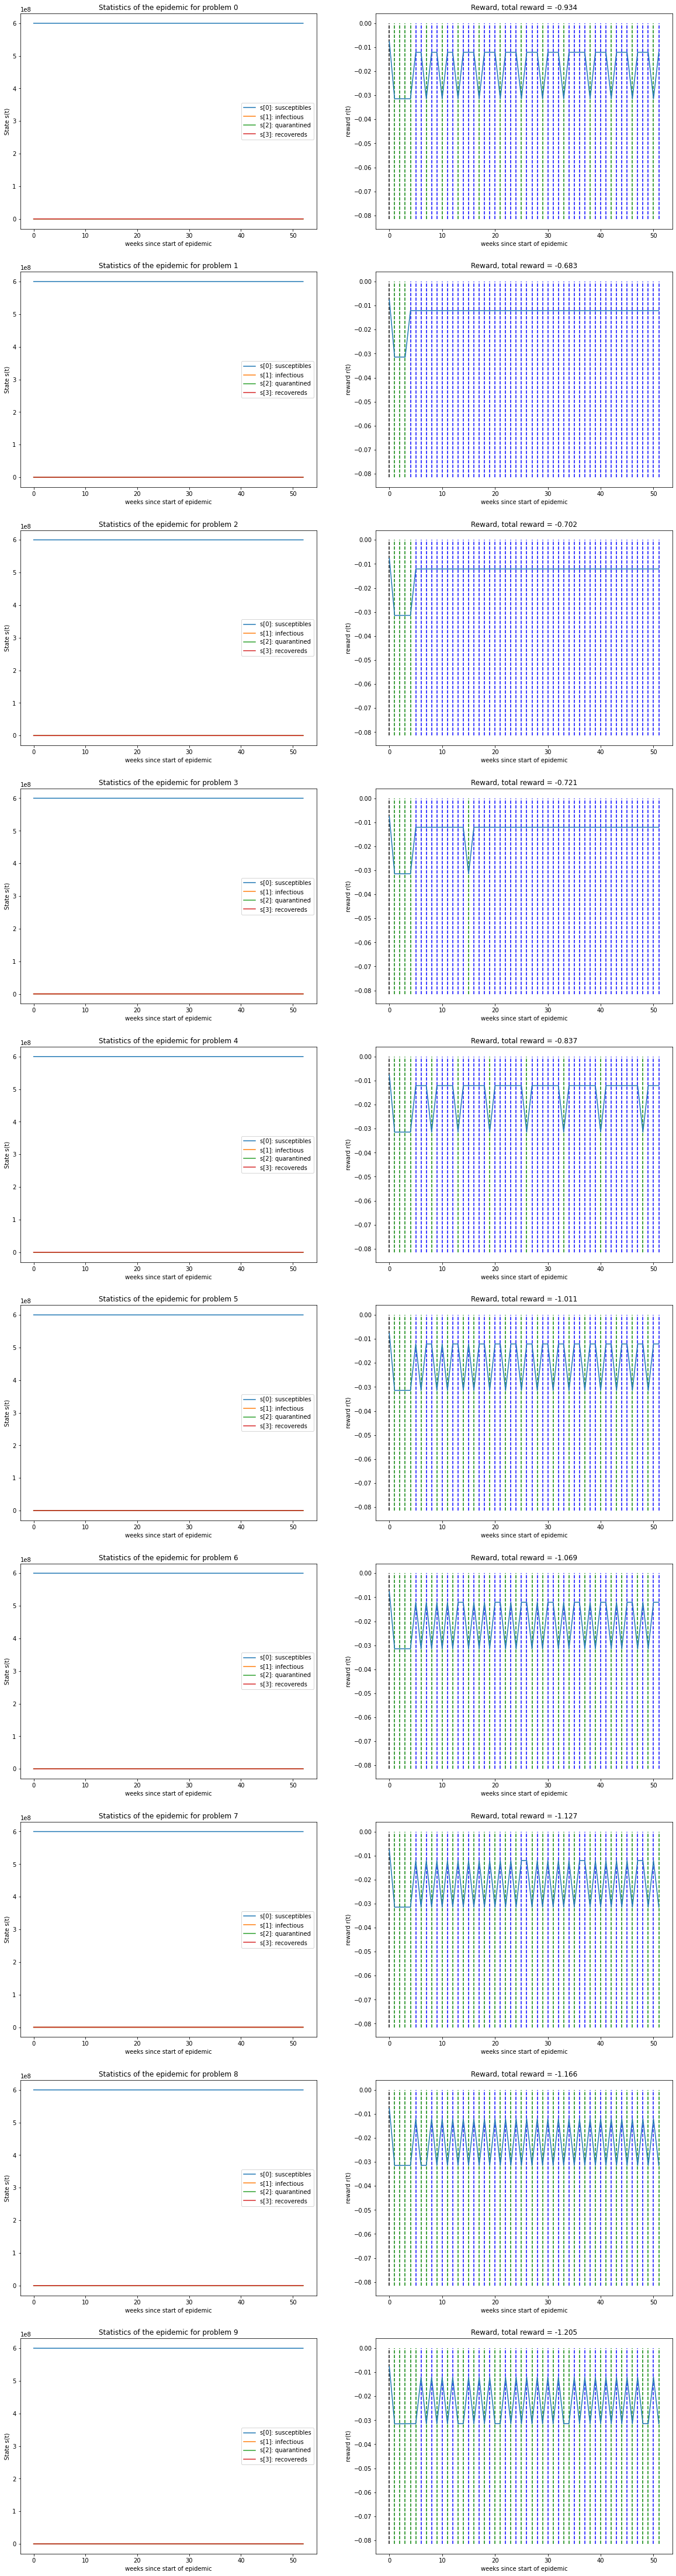

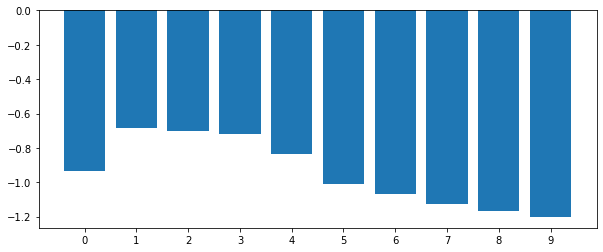

In [15]:
utils.evaluate(approximator_dl, full_eval=True, verbose=False)

### Full evaluation without noise

[-0.9338959555531453,
 -0.6826118991366483,
 -0.70194667929197,
 -0.7213163269619391,
 -0.837268113961144,
 -1.011224485529036,
 -1.0692238135830414,
 -1.1272596106583246,
 -1.1659811371244577,
 -1.2046822071445744]

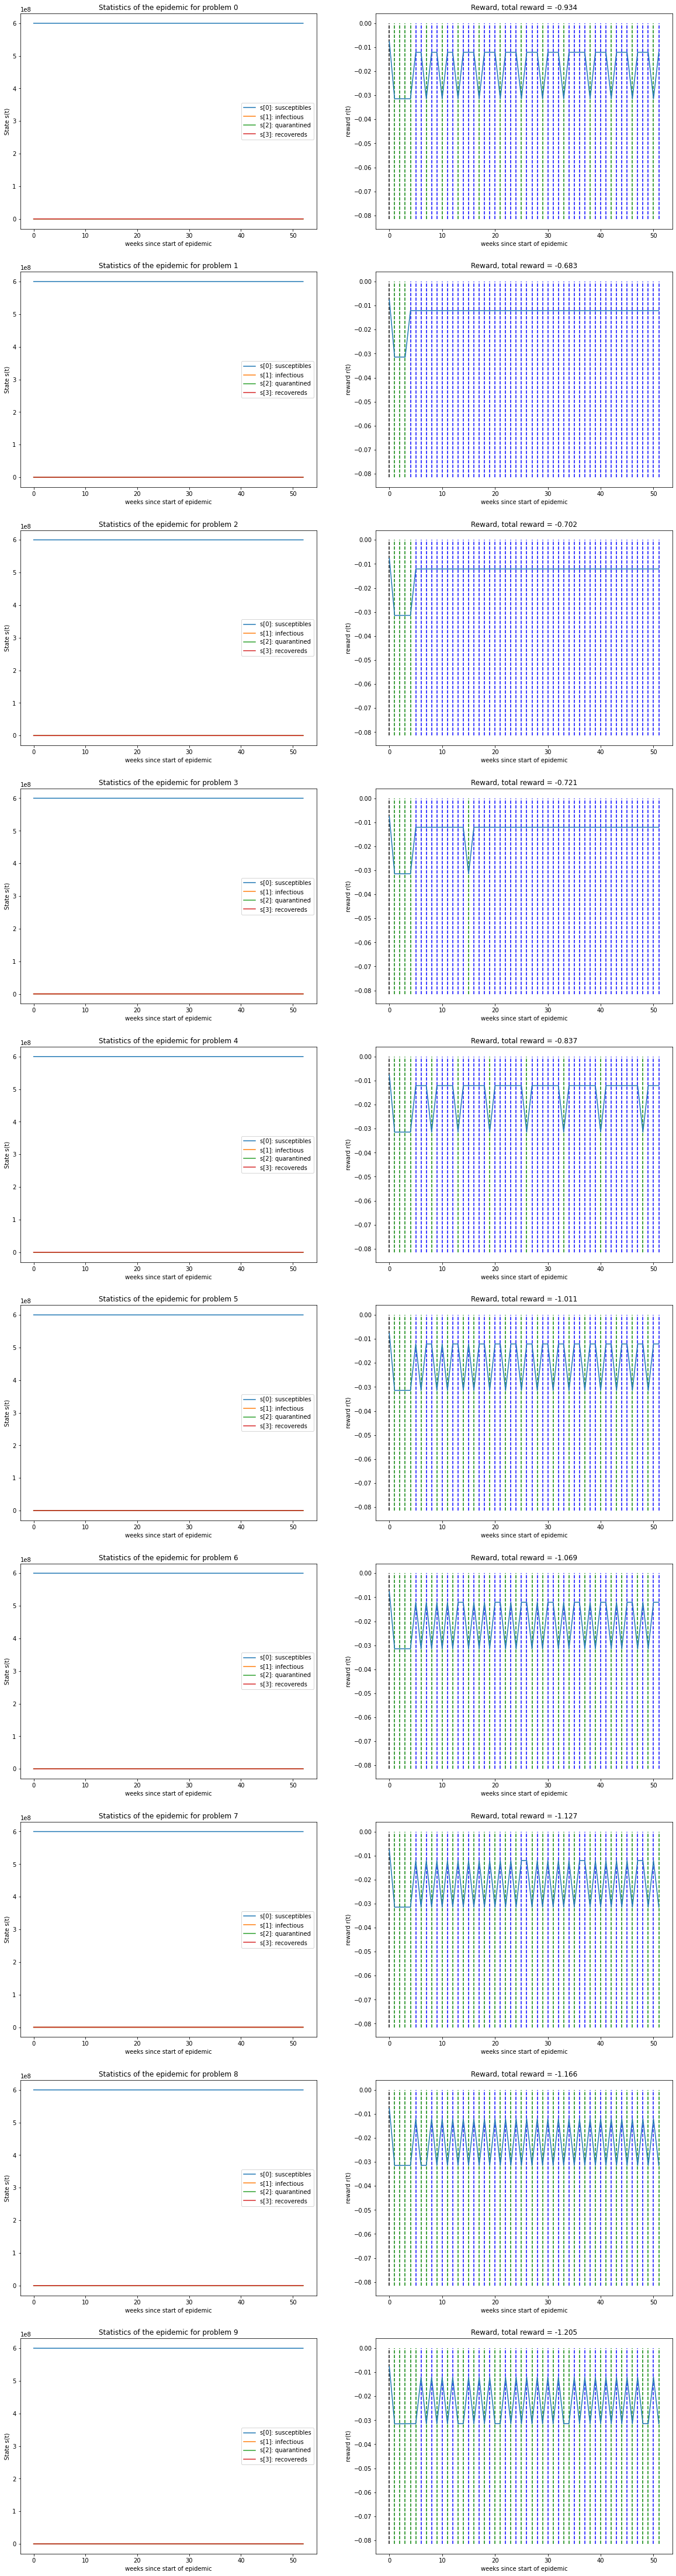

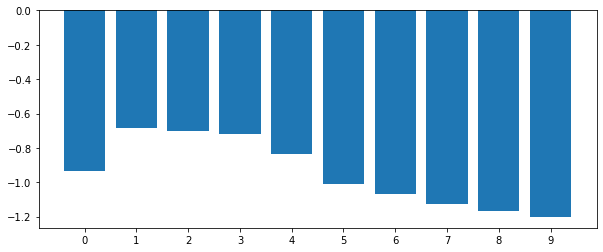

In [16]:
utils.evaluate(approximator_dl, full_eval=True, verbose=False)

### Full evaluation with noise

[-0.9338975686589174,
 -0.6826118991366483,
 -0.6826398665029707,
 -0.7213173712016281,
 -0.837268113961144,
 -1.011224485529036,
 -1.0692238135830414,
 -1.1272560910038285,
 -1.1659811371244577,
 -1.2046822071445744]

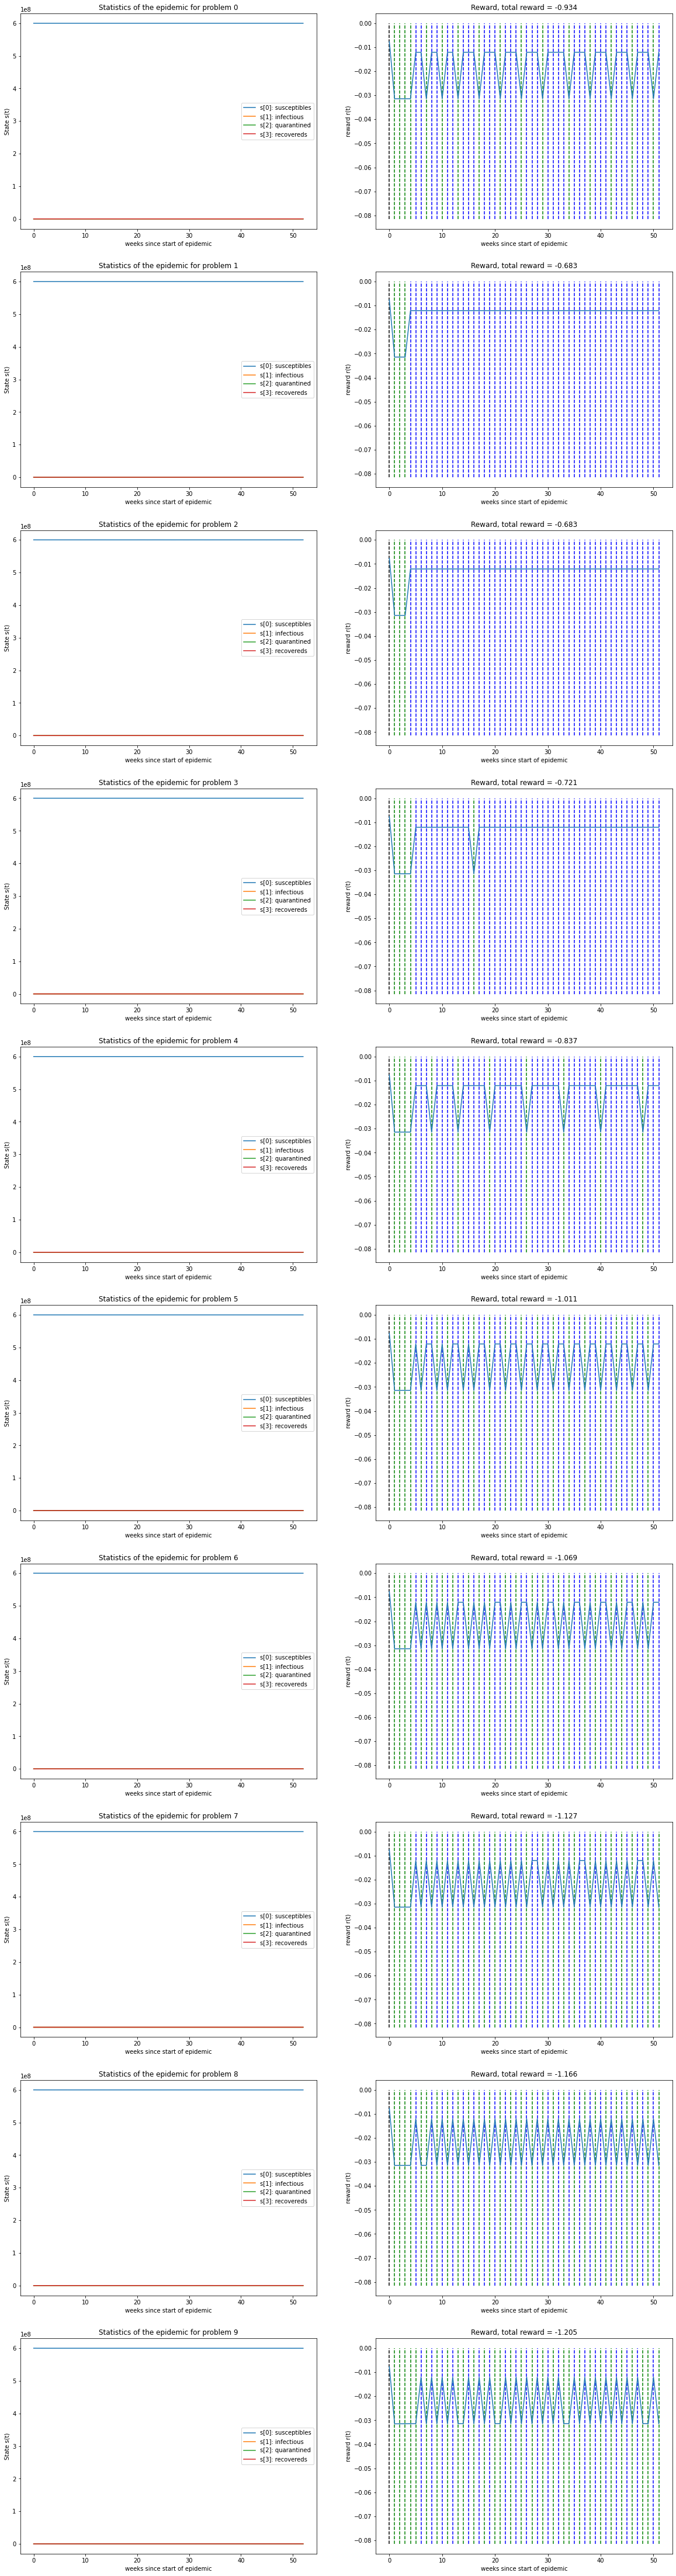

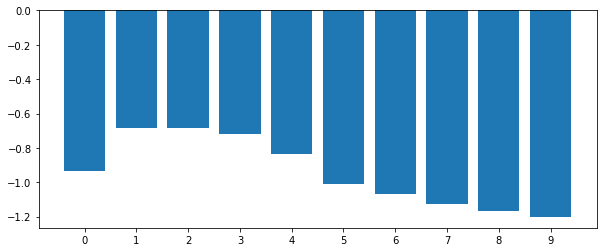

In [17]:
utils.evaluate(approximator_dl, full_eval=True, noisy=True, verbose=False)

### Stochastic analysis with noise

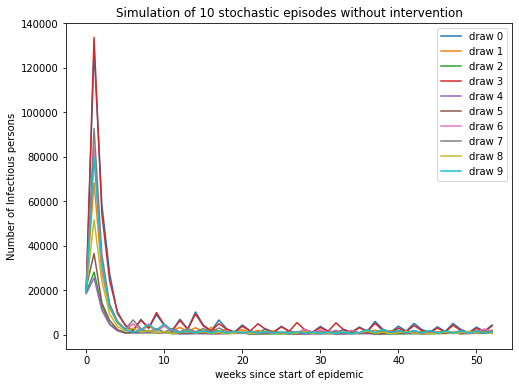

In [18]:
utils.evaluate_stochastic(approximator_dl)

In [21]:
for env in [virl.Epidemic(problem_id=i) for i in range(10)]:
    print(utils.compare_with_greedy(approximator_dl, env))

-0.05387055100979321
-0.3647584339964156
-0.2152761912161097
-0.08667994217113095
-0.06315584656849726
-0.0434722769402508
-0.01819249552245883
-0.03741588411466057
-0.04117894496457275
-0.021835360944911786
